In [36]:
import os
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from termcolor import colored

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, KFold,GridSearchCV
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor,StackingRegressor, RandomForestRegressor, ExtraTreesRegressor
from sklearn.linear_model import Lasso
from sklearn.pipeline import make_pipeline

from scipy.stats import skew
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from scipy.stats import boxcox
from scipy.special import inv_boxcox

from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler

In [37]:
#import sys;
#sys.path.append('../../globalfunction');
import functions_20221007


In [38]:
runBad = False
if runBad:
    import lightgbm as lgb
    import xgboost as xgb

In [39]:
if runBad:
    train_data = pd.read_csv('../input/house-prices-advanced-regression-techniques/train.csv')
    test_data = pd.read_csv('../input/house-prices-advanced-regression-techniques/test.csv')
    print(colored(f"Training data", "blue"), "-> ROWS:", train_data.shape[0], "COLUMNS:", train_data.shape[1])
    print(colored(f"Test data", "red"), "-> ROWS:", test_data.shape[0], "COLUMNS:", test_data.shape[1])


In [40]:
LABEL = 'Price'

booleans = ['analyticsProperty.soldSTC','sharedOwnership.sharedOwnership']

floats = ['location.latitude', 'location.longitude', 'bedrooms', 'bathrooms',
          'nearestStation','nearestTram','nearestUnderground','nearestOverground',
          ]

categories = ['tenure.tenureType',
              'analyticsProperty.preOwned',
              'analyticsProperty.propertyType',  # 'propertyType',
               #'analyticsProperty.propertySubType',
               #'borough',
              ]

In [41]:
def get_source_dataframe(prefix = '../'):
    df = pd.read_csv(prefix + 'data/source/df_listings.csv', on_bad_lines='skip', index_col=0)
    return df


def create_train_test_data(df, return_index=False, drop_nulls=True):

    if drop_nulls:
        df.dropna(inplace=True)

    if return_index:
        df.reset_index(inplace=True)

    for column in categories:
        df = pd.concat([df, pd.get_dummies(df[column], prefix=column)], axis=1)
        df.drop([column], axis=1, inplace=True)  # now drop the original column (you don't need it anymore),

    features = df[df.columns[1:]].values
    labels = df[LABEL].values

    if not return_index:
        return train_test_split(features, labels, train_size=0.7, random_state=1)
    else:
        X_train1, X_test1, y_train1, y_test1 = train_test_split(features, labels, train_size=0.7, random_state=1)
        X_train_index = X_train1[0]
        y_train_index = y_train1[0]
        X_test_index = X_test1[0]
        y_test_index = y_test1[0]
        X_train1 = X_train1[1:]
        y_train1 = y_train1[1:]
        X_test1 = X_test1[1:]
        y_test1 = y_test1[1:]
        return X_train1, X_test1, y_train1, y_test1, X_train_index, y_train_index, X_test_index, y_test_index

In [42]:
df = get_source_dataframe(prefix='../../')
df[:5]

,Price,location.latitude,location.longitude,bedrooms,bathrooms,nearestStation,nearestTram,nearestUnderground,nearestOverground,tenure.tenureType,analyticsProperty.soldSTC,analyticsProperty.preOwned,sharedOwnership.sharedOwnership,analyticsProperty.propertyType,analyticsProperty.propertySubType,borough
14520525,550000,51.529950,-0.207020,3.0,1.0,0.274316,NaN,0.274316,0.274316,LEASEHOLD,False,Resale,False,Flats / Apartments,Maisonette,Westminster
27953107,400000,51.549390,-0.482600,2.0,2.0,0.305845,NaN,0.305845,NaN,LEASEHOLD,False,Resale,False,Flats / Apartments,Apartment,Hillingdon
33593487,579950,51.447180,-0.338770,2.0,1.0,0.438045,NaN,NaN,0.438045,FREEHOLD,False,Resale,False,Houses,Terraced,Richmond upon Thames
35271294,370000,51.449568,-0.140154,2.0,1.0,0.399307,NaN,0.399307,0.704048,LEASEHOLD,False,Resale,False,Flats / Apartments,Flat,Lambeth
35429088,599950,51.577030,-0.141230,2.0,1.0,0.238187,NaN,0.238187,1.054653,NaN,False,Resale,False,Flats / Apartments,Flat,Haringey


In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26633 entries, 14520525 to 121678256
Data columns (total 16 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Price                              26633 non-null  int64  
 1   location.latitude                  26628 non-null  float64
 2   location.longitude                 26633 non-null  float64
 3   bedrooms                           25670 non-null  float64
 4   bathrooms                          24915 non-null  float64
 5   nearestStation                     26633 non-null  float64
 6   nearestTram                        1675 non-null   float64
 7   nearestUnderground                 14048 non-null  float64
 8   nearestOverground                  23577 non-null  float64
 9   tenure.tenureType                  24823 non-null  object 
 10  analyticsProperty.soldSTC          26633 non-null  bool   
 11  analyticsProperty.preOwned         26633 no

In [44]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Price,26633.0,410493.420719,113954.799595,100000.000000,325000.000000,415000.000000,500000.000000,600000.000000
location.latitude,26628.0,51.497605,0.075702,51.298320,51.442726,51.501050,51.553926,51.683060
location.longitude,26633.0,-0.109379,0.724300,-0.497861,-0.218288,-0.106180,-0.013215,51.558746
bedrooms,25670.0,1.976237,0.828547,1.000000,1.000000,2.000000,2.000000,7.000000
bathrooms,24915.0,1.180935,0.407462,1.000000,1.000000,1.000000,1.000000,5.000000
nearestStation,26633.0,0.446379,1.259971,0.000000,0.220947,0.359822,0.556251,192.431869
nearestTram,1675.0,0.586149,0.529699,0.005282,0.271044,0.482094,0.749169,3.769980
nearestUnderground,14048.0,0.563408,0.492926,0.006731,0.265666,0.441683,0.709013,16.153746
nearestOverground,23577.0,0.504417,1.335473,0.000000,0.253201,0.414946,0.632774,192.431869


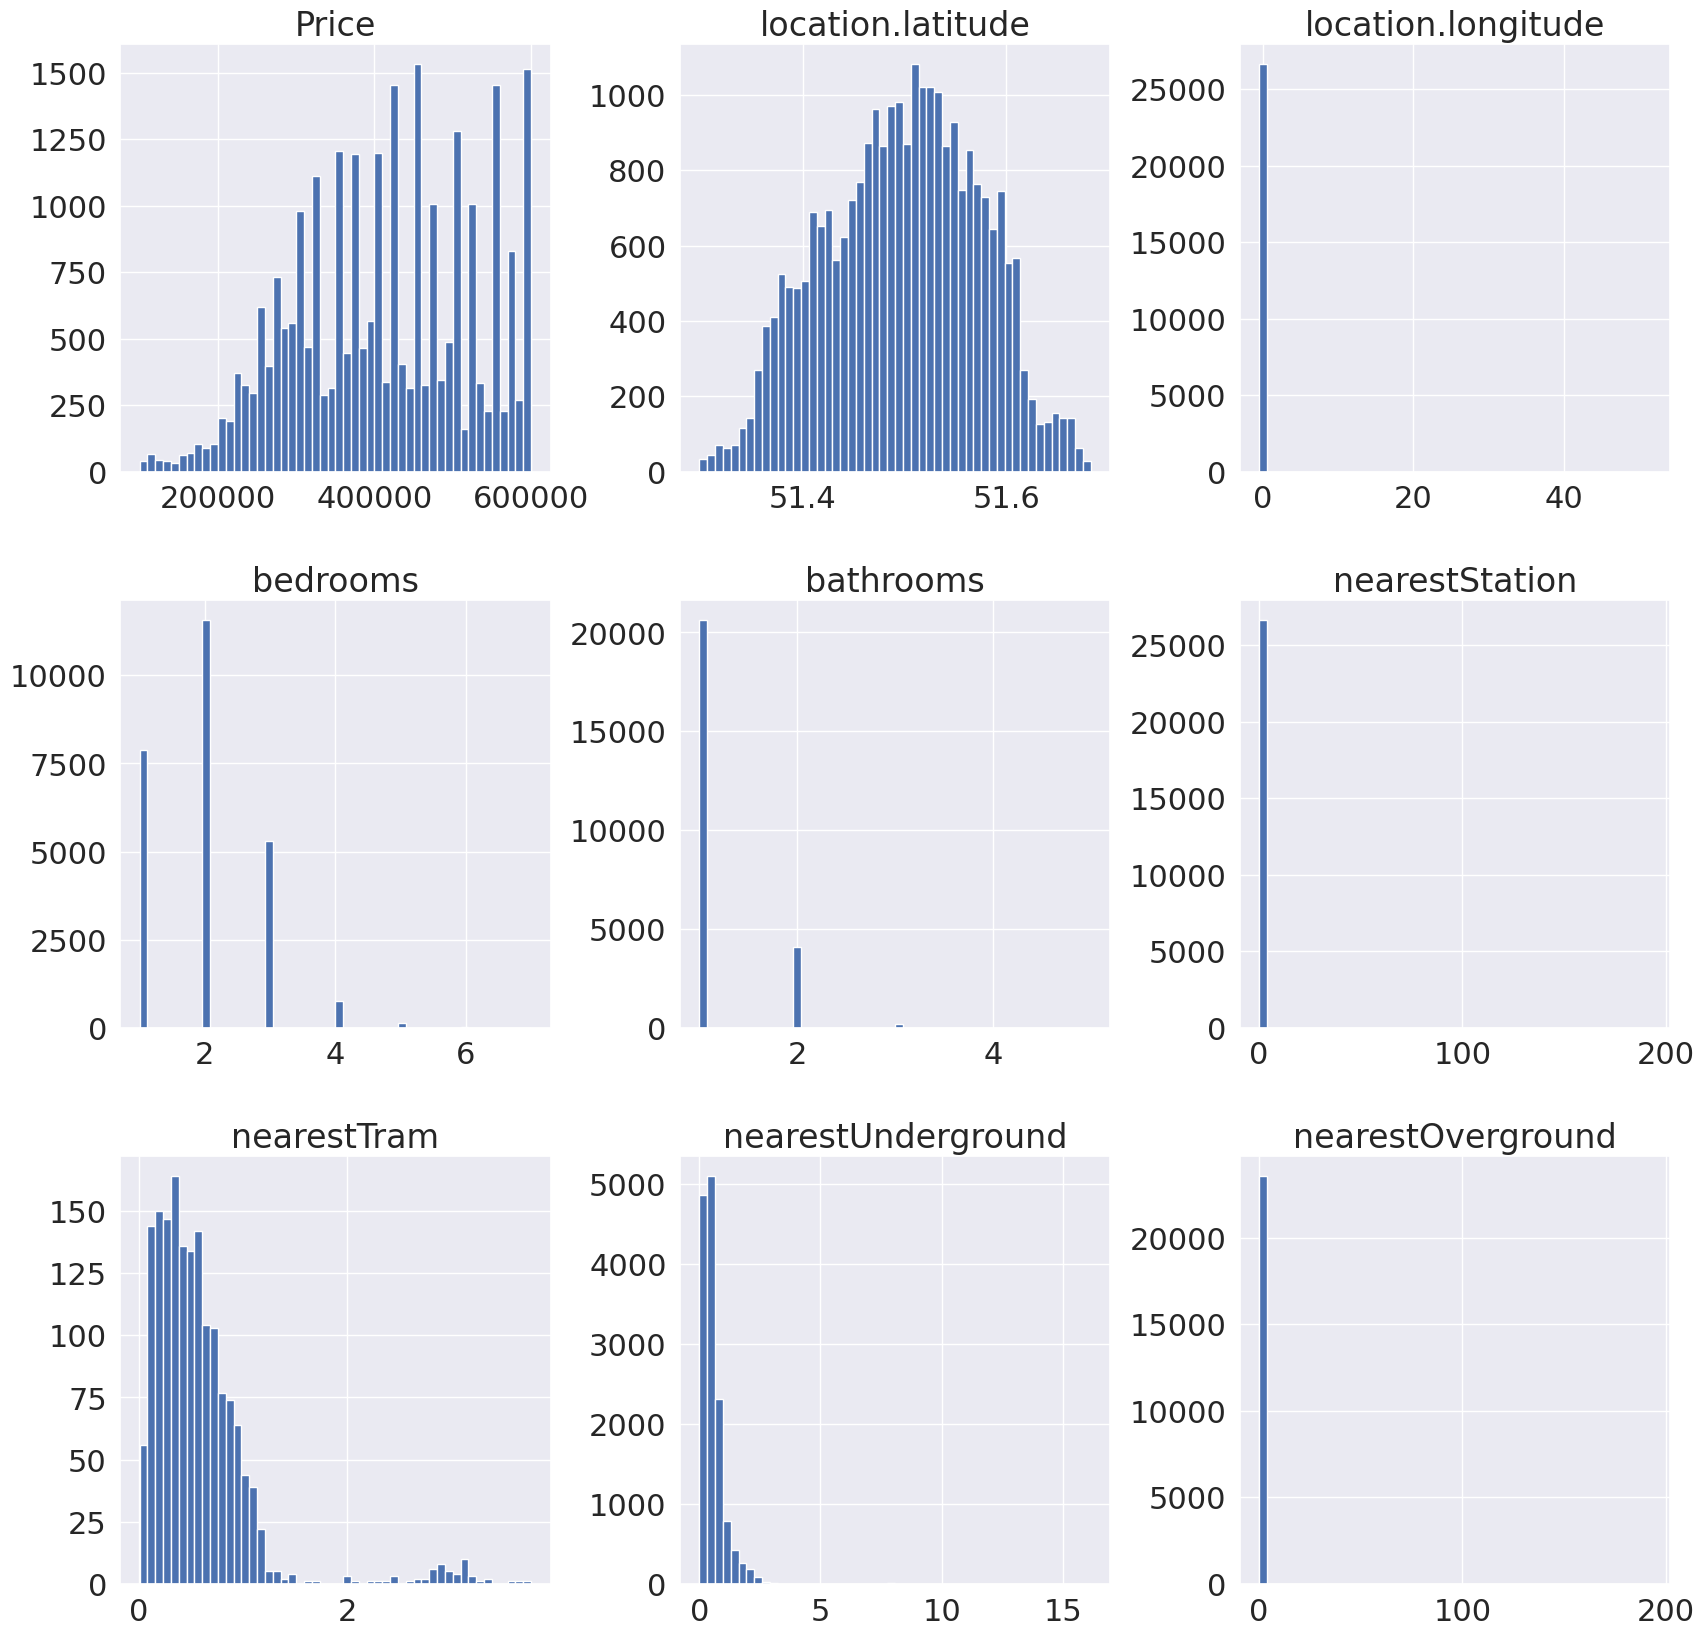

In [45]:
%matplotlib inline
df.hist(bins=50, figsize=(20,20))
plt.show()

train_data.describe()

<div id = 3 style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#b08888;
           font-size:100%;
           font-family:Verdana;
           letter-spacing:0.5px;
           display:flex;
            justify-content:center;">

<h2 style="padding: 2rem;
              color:white;
          text-align:center;
          margin:0 auto;
          ">
    REMOVE OUTLIERS


</h2>
</div>

In [46]:
df = df[(df['location.longitude'] < 10)]
df = df[(df['nearestStation'] < 5)]
df = df[(df['nearestOverground'] < 5)]

df.describe().T

,count,mean,std,min,25%,50%,75%,max
Price,23561.0,408629.696999,113947.880586,100000.000000,325000.000000,410000.000000,500000.000000,600000.000000
location.latitude,23561.0,51.494145,0.074778,51.298320,51.439010,51.495730,51.549380,51.683060
location.longitude,23561.0,-0.114359,0.156054,-0.497861,-0.210830,-0.099560,-0.013020,0.278672
bedrooms,22785.0,1.971209,0.824993,1.000000,1.000000,2.000000,2.000000,6.000000
bathrooms,22053.0,1.179159,0.405898,1.000000,1.000000,1.000000,1.000000,5.000000
nearestStation,23561.0,0.435829,0.318672,0.000000,0.221783,0.362152,0.560376,3.687893
nearestTram,1195.0,0.607789,0.462339,0.017866,0.312155,0.546216,0.793260,3.769980
nearestUnderground,11406.0,0.594356,0.461663,0.012082,0.276847,0.470237,0.752729,3.064153
nearestOverground,23561.0,0.491457,0.350488,0.000000,0.253201,0.414863,0.631985,3.997993


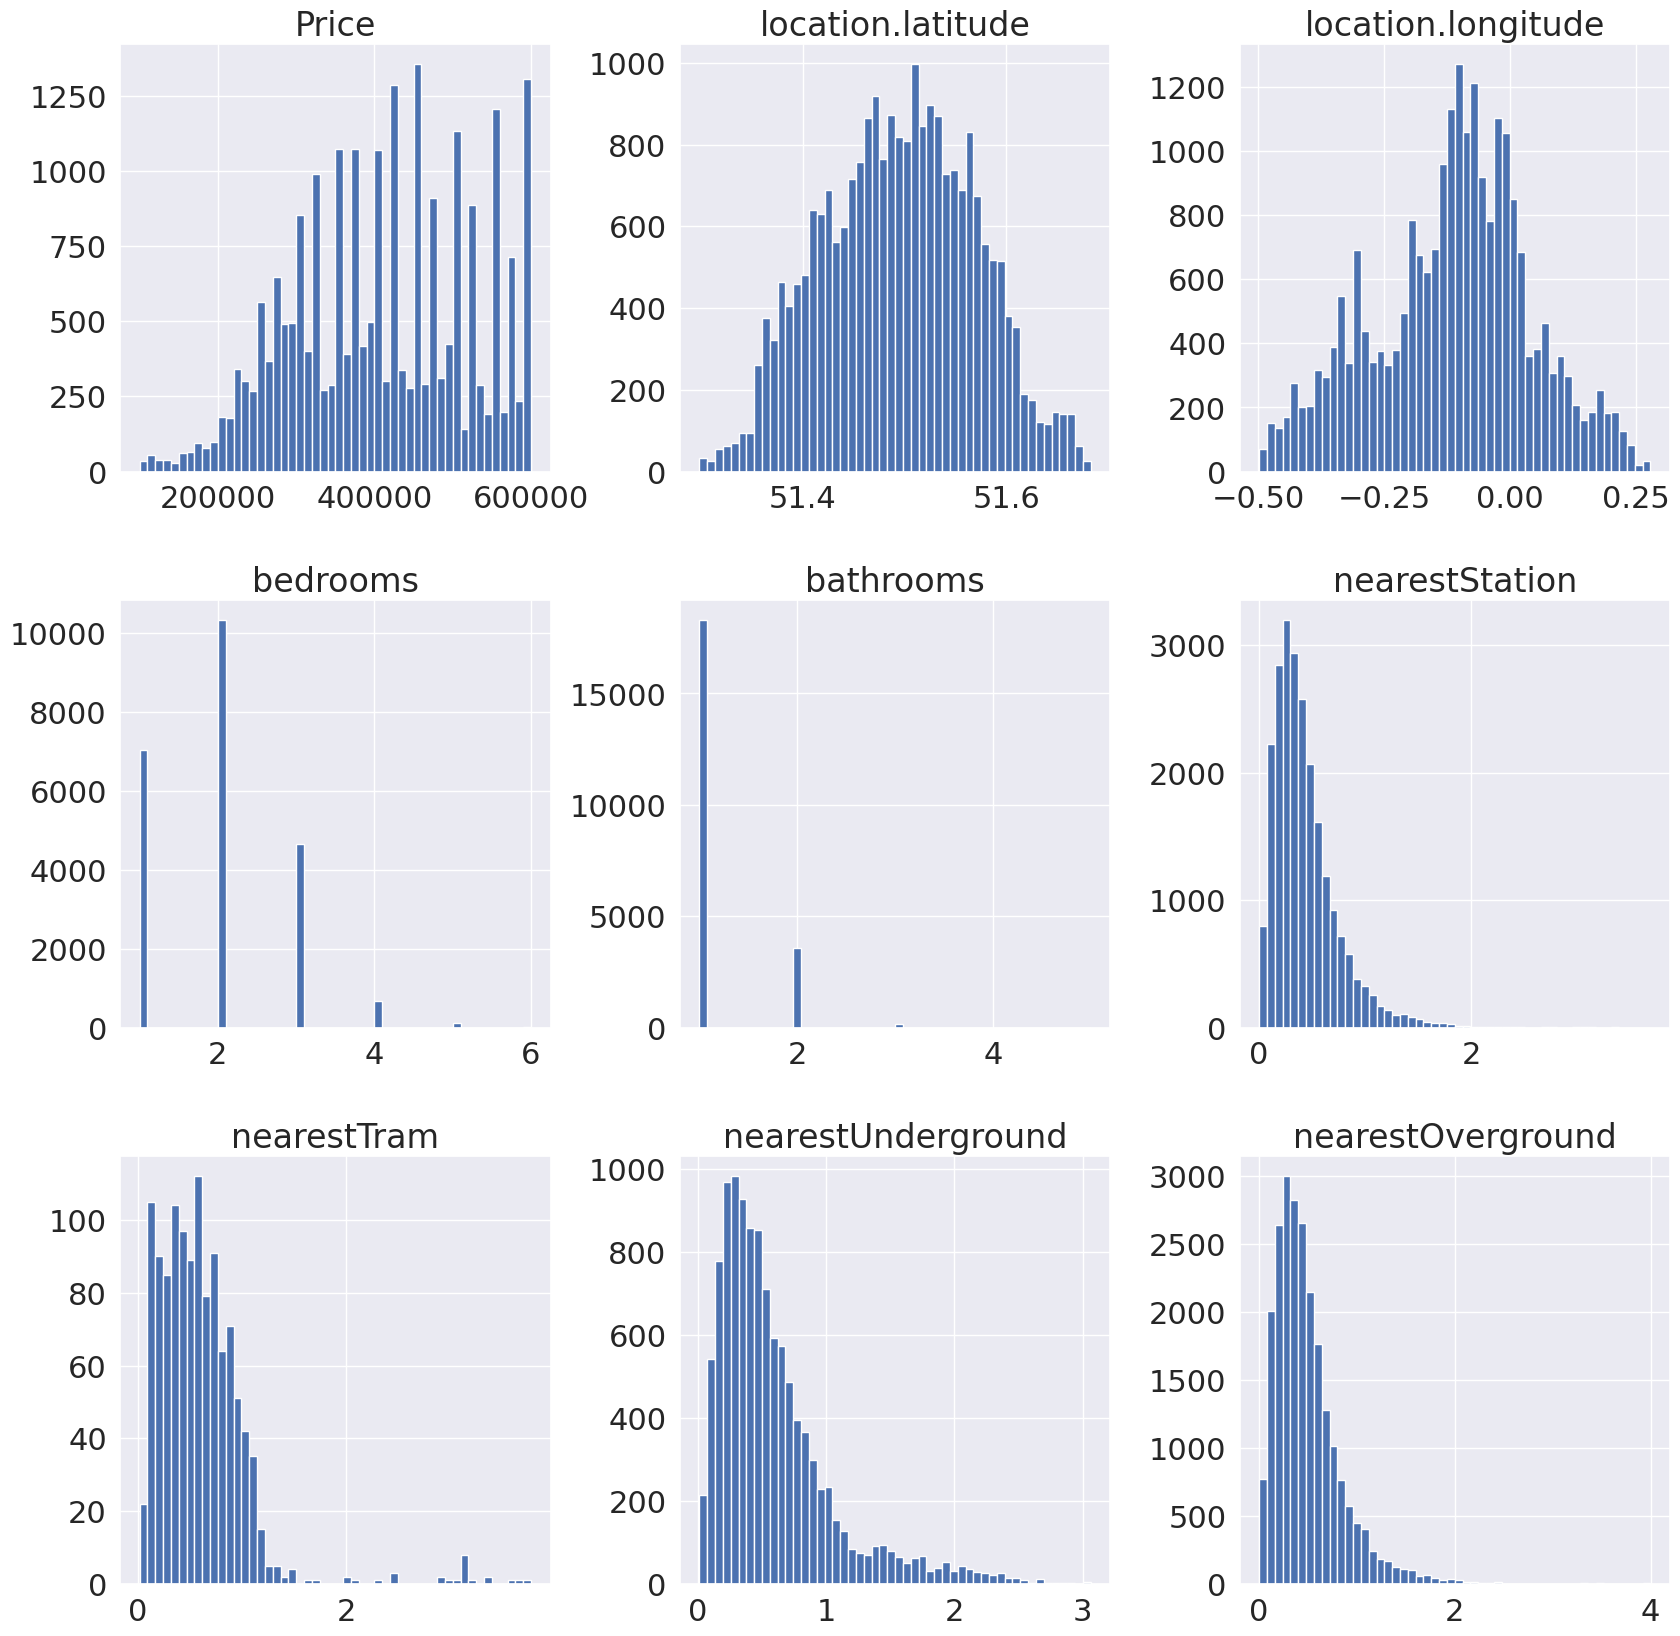

In [47]:
df.hist(bins=50, figsize=(20,20))
plt.show()

In [48]:
for column in categories:
    df = pd.concat([df, pd.get_dummies(df[column], prefix=column)], axis=1)
    df.drop([column], axis=1, inplace=True)  # now drop the original column (you don't need it anymore),

corr = df.corr()
corr

,Price,location.latitude,location.longitude,bedrooms,bathrooms,nearestStation,nearestTram,nearestUnderground,nearestOverground,analyticsProperty.soldSTC,...,tenure.tenureType_FREEHOLD,tenure.tenureType_LEASEHOLD,tenure.tenureType_SHARE_OF_FREEHOLD,analyticsProperty.preOwned_New Home,analyticsProperty.preOwned_Resale,analyticsProperty.propertyType_Bungalows,analyticsProperty.propertyType_Character Property,analyticsProperty.propertyType_Flats / Apartments,analyticsProperty.propertyType_Houses,analyticsProperty.propertyType_Not Specified
Price,1.000000,0.047401,-0.046315,0.466595,0.275176,-0.022698,0.025632,-0.122449,-0.006488,-0.039044,...,0.354469,-0.331336,0.061075,0.054357,-0.054357,0.085045,-0.003352,-0.369131,0.358179,-0.015239
location.latitude,0.047401,1.000000,0.127113,0.008934,-0.007555,0.036954,-0.436633,0.079963,0.105939,0.010515,...,0.011586,0.008346,-0.053409,-0.048255,0.048255,-0.005613,0.014425,-0.018982,0.018254,0.016408
location.longitude,-0.046315,0.127113,1.000000,0.082106,0.010257,-0.012792,0.044767,-0.156136,-0.062948,0.133634,...,0.093383,-0.030156,-0.070812,-0.013478,0.013478,0.049411,0.002972,-0.101658,0.091085,-0.000665
bedrooms,0.466595,0.008934,0.082106,1.000000,0.335107,0.241033,0.198258,0.243314,0.221468,0.174352,...,0.551411,-0.417143,-0.097571,-0.070318,0.070318,0.067156,0.000231,-0.586288,0.582961,-0.003279
bathrooms,0.275176,-0.007555,0.010257,0.335107,1.000000,0.044693,0.001599,0.095540,0.038844,0.001032,...,0.094860,-0.042415,-0.059454,0.099200,-0.099200,0.000555,NaN,-0.105968,0.110796,-0.015484
nearestStation,-0.022698,0.036954,-0.012792,0.241033,0.044693,1.000000,0.837549,0.724105,0.889249,0.167264,...,0.304241,-0.212204,-0.078975,-0.053541,0.053541,0.109804,0.003964,-0.327398,0.307394,-0.007086
nearestTram,0.025632,-0.436633,0.044767,0.198258,0.001599,0.837549,1.000000,0.842316,0.785749,0.086596,...,0.214943,-0.127151,-0.143505,0.040314,-0.040314,0.081670,NaN,-0.252867,0.237355,0.001889
nearestUnderground,-0.122449,0.079963,-0.156136,0.243314,0.095540,0.724105,0.842316,1.000000,0.485265,0.199452,...,0.318160,-0.208494,-0.093986,-0.053909,0.053909,0.104074,NaN,-0.348906,0.333266,-0.004241
nearestOverground,-0.006488,0.105939,-0.062948,0.221468,0.038844,0.889249,0.785749,0.485265,1.000000,0.137018,...,0.283551,-0.197640,-0.074384,-0.054478,0.054478,0.099148,0.002570,-0.302665,0.285440,-0.010622
analyticsProperty.soldSTC,-0.039044,0.010515,0.133634,0.174352,0.001032,0.167264,0.086596,0.199452,0.137018,1.000000,...,0.240885,-0.186093,-0.023408,-0.094395,0.094395,0.050999,0.006707,-0.253789,0.246249,0.001835


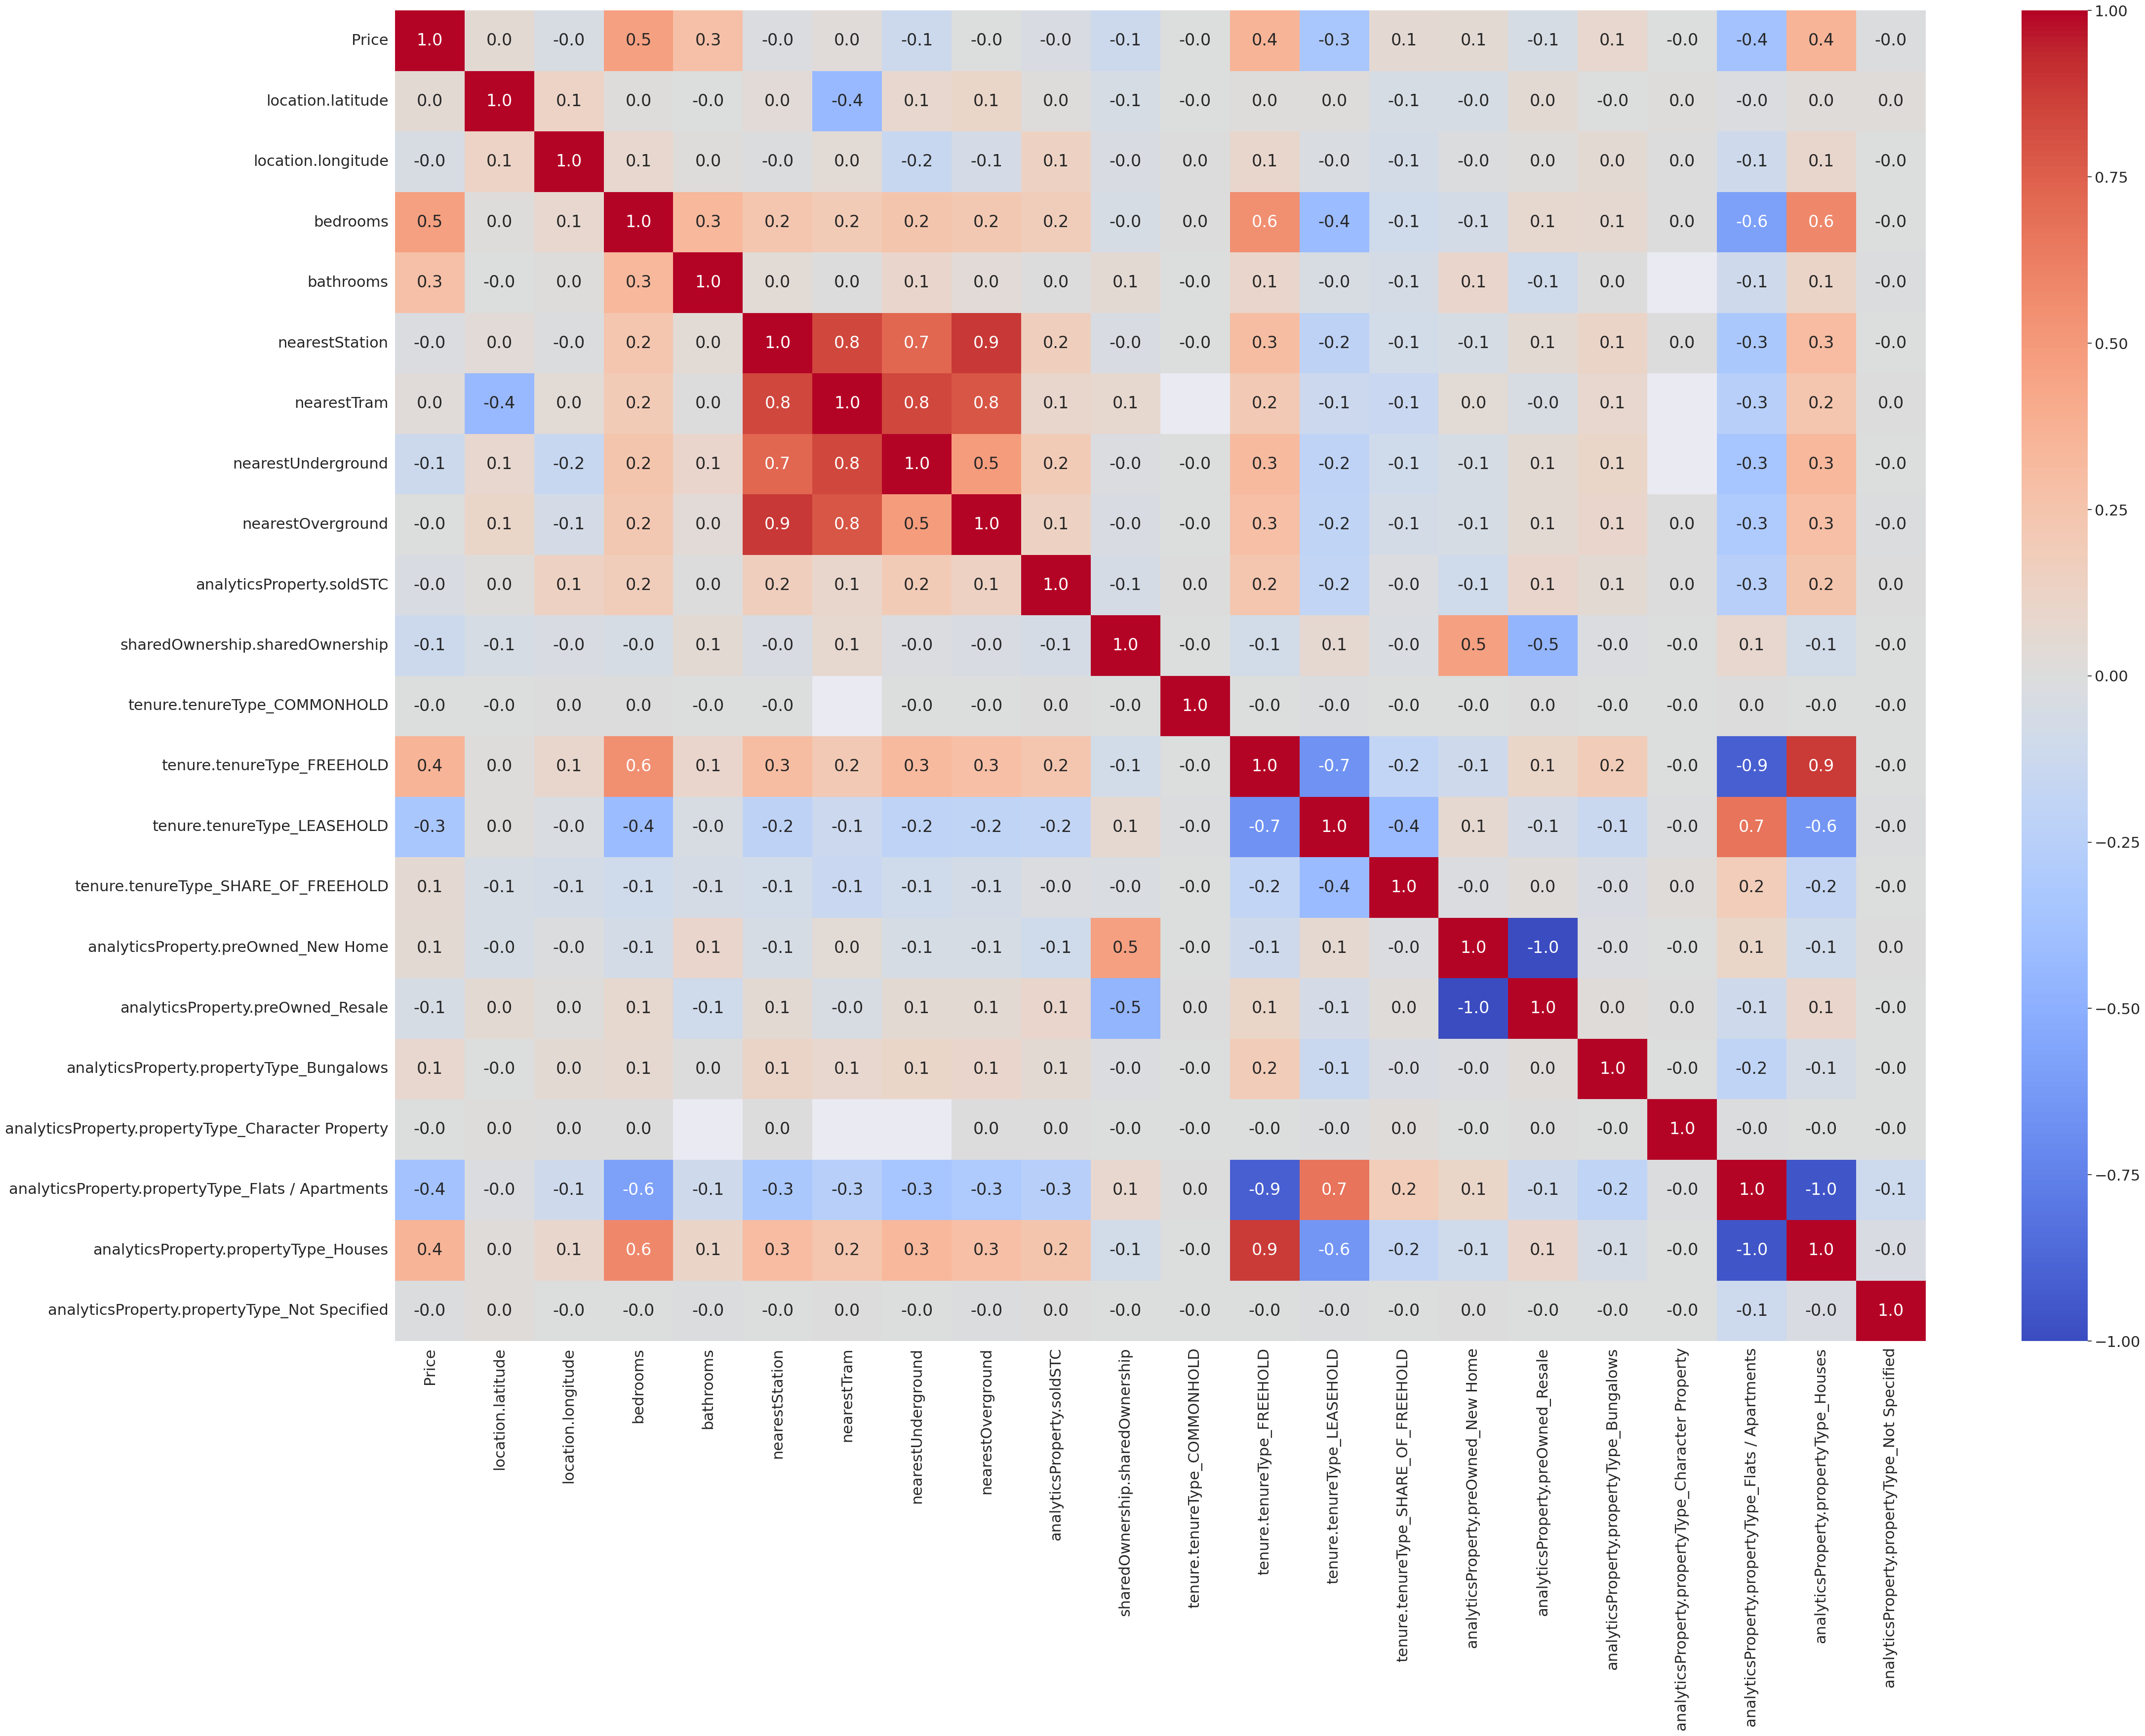

In [49]:
sns.set(font_scale=2)
plt.figure(figsize=(50,35))
ax = sns.heatmap(corr,annot=True,fmt='.1f',cmap='coolwarm')

In [51]:
corr_dict = corr["Price"].sort_values(ascending=False).to_dict()
corr_dict

{'Price': 1.0,
 'bedrooms': 0.4665952641484936,
 'analyticsProperty.propertyType_Houses': 0.3581786027300316,
 'tenure.tenureType_FREEHOLD': 0.35446858539707293,
 'bathrooms': 0.2751763211126154,
 'analyticsProperty.propertyType_Bungalows': 0.08504468400814533,
 'tenure.tenureType_SHARE_OF_FREEHOLD': 0.0610752602566426,
 'analyticsProperty.preOwned_New Home': 0.05435668691617547,
 'location.latitude': 0.047400899864739304,
 'nearestTram': 0.025631500675885818,
 'tenure.tenureType_COMMONHOLD': -0.0033305605823811682,
 'analyticsProperty.propertyType_Character Property': -0.0033522235401812375,
 'nearestOverground': -0.006487518291333398,
 'analyticsProperty.propertyType_Not Specified': -0.015239454684316289,
 'nearestStation': -0.022697635322517392,
 'analyticsProperty.soldSTC': -0.03904373446011975,
 'location.longitude': -0.04631488335591194,
 'analyticsProperty.preOwned_Resale': -0.05435668691617574,
 'nearestUnderground': -0.12244923894849385,
 'sharedOwnership.sharedOwnership': -0.

In [52]:
#print the most positively correlated features
pos_corr = {k:v for k,v in corr_dict.items() if v > 0.1 and v != 1}
pos_corr

{'bedrooms': 0.4665952641484936,
 'analyticsProperty.propertyType_Houses': 0.3581786027300316,
 'tenure.tenureType_FREEHOLD': 0.35446858539707293,
 'bathrooms': 0.2751763211126154}

In [54]:
#print the most negatively correlated features
neg_corr = {k:v for k,v in corr_dict.items() if v < -0.1}
neg_corr

{'nearestUnderground': -0.12244923894849385,
 'sharedOwnership.sharedOwnership': -0.12325110499470697,
 'tenure.tenureType_LEASEHOLD': -0.33133602034394344,
 'analyticsProperty.propertyType_Flats / Apartments': -0.369131322136432}

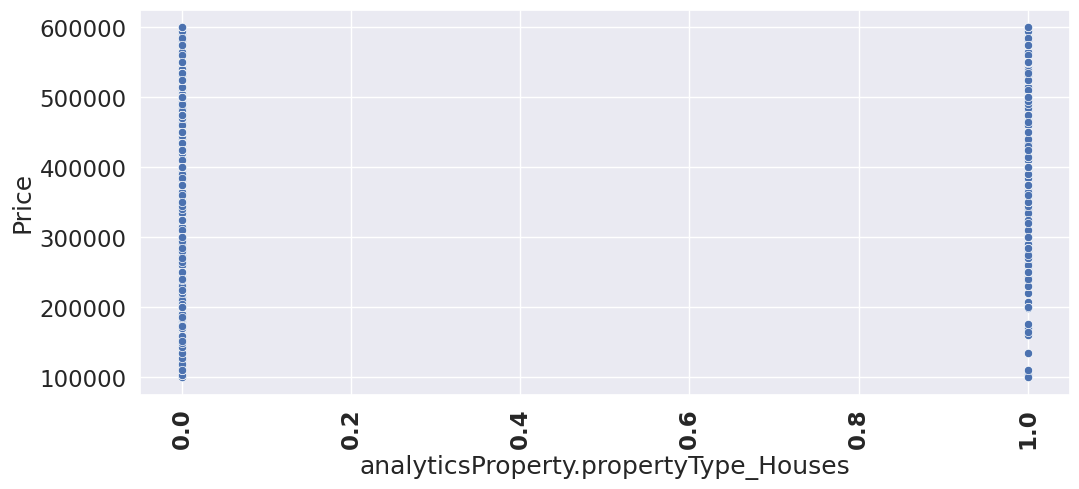

In [58]:
plt.figure(figsize=(12,5))
sns.set(font_scale=1.5)
sns.scatterplot(x='nearestUnderground', y='Price', data=df)
plt.xticks(weight='bold',rotation=90)
plt.show()